# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Uniform Cost Search
* A\* Search
* Genetic Algorithm

## OVERVIEW

Here, we learn about problem solving. Building goal-based agents that can plan ahead to solve problems, in particular, navigation problem/route finding problem. First, we will start the problem solving by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms. Broadly, search algorithms are classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
* Examples:
    1. Breadth First Search
    2. Depth First Search
    3. Depth Limited Search
    4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
* Examples:
    1. Best First Search
    2. Uniform Cost Search
    3. A\* Search
    4. Recursive Best First Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [2]:
%psource Problem

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor` and is the first method called when you create an instance of the class. `initial` specifies the initial state of our search problem. It represents the start state from where our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Given a graph state, it checks if it is a terminal state. If the state is indeed a goal state, value of `True` is returned. Else, of course, `False` is returned.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [3]:
%psource GraphProblem

Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [4]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Hmm... say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [5]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [6]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's start the visualisations by importing necessary modules. We use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works.

In [7]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [8]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

# we'll save the initial node colors to a dict to use later
initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_locations.items() }

# use this while labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]

        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

In [9]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

# we'll save the initial node colors to a dict to use later
initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_locations.items() }

# use this while labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]

        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

In [10]:
def show_map(node_colors):
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos = romania_locations, node_color = [node_colors[node] for node in G.nodes()])

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos = node_label_pos, labels = node_labels, font_size = 14)
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos = romania_locations, edge_labels=edge_labels, font_size = 14)
    
    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1,prop={'size':16}, loc=(.8,.75))
    
    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

We can simply call the function with node_colors dictionary object to display it.

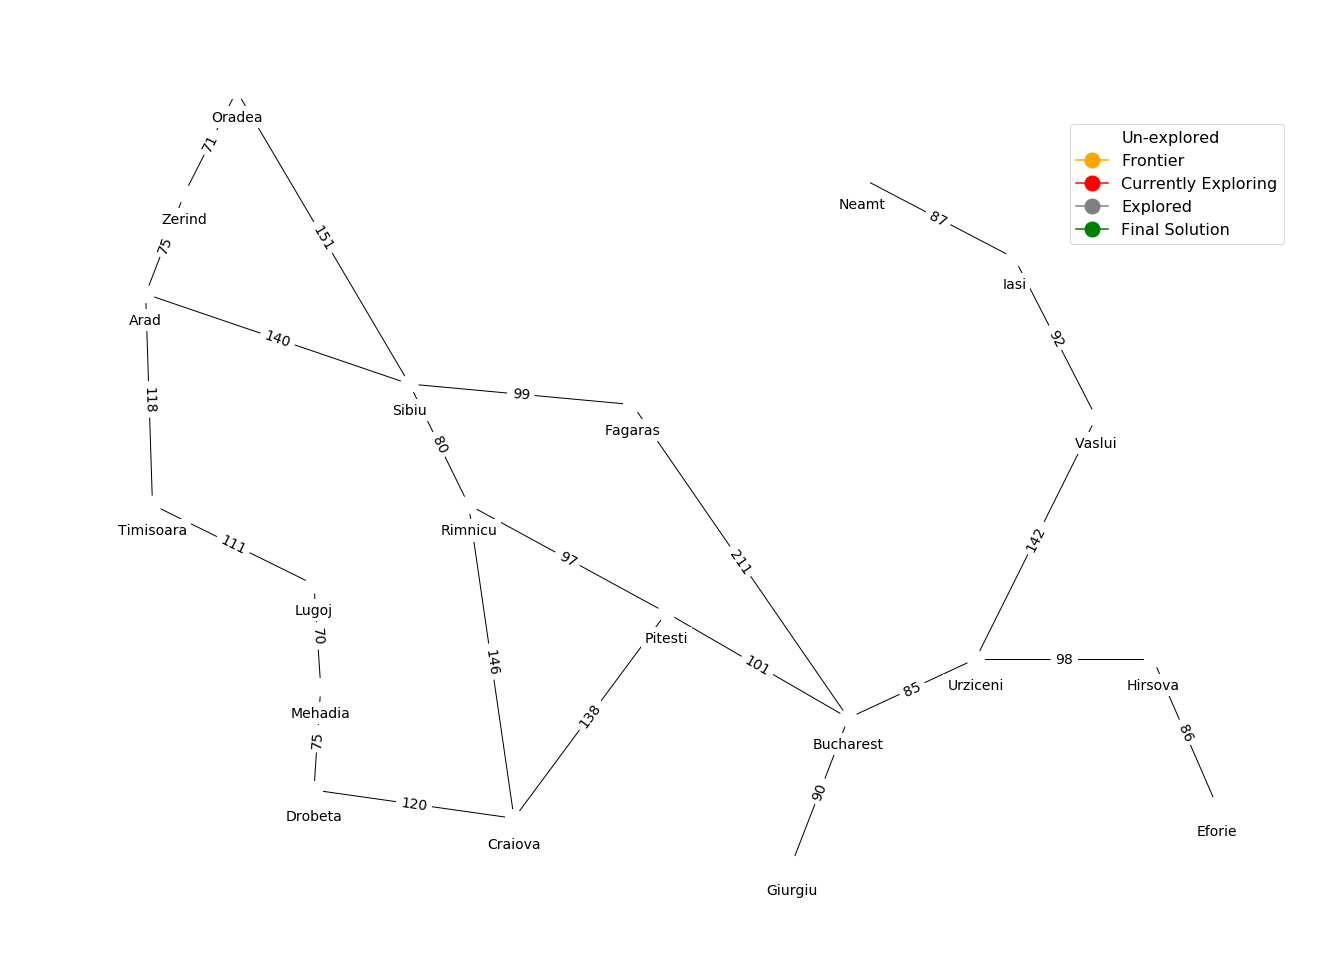

In [11]:
show_map(node_colors)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:

1. Breadth First Tree Search - Implemented
2. Depth First Tree Search - Implemented
3. Depth First Graph Search - Implemented
4. Breadth First Search - Implemented
5. Best First Graph Search
6. Uniform Cost Search - Implemented
7. Depth Limited Search
8. Iterative Deepening Search
9. A\*-Search - Implemented
10. Recursive Best First Search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

Now, we will define some helper methods to display interactive buttons and sliders when visualising search algorithms.

In [12]:
def final_path_colors(problem, solution):
    "returns a node_colors dict of the final path provided the problem and solution"
    
    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"  
    return final_colors


def display_visual(user_input, algorithm=None, problem=None):
    if user_input == False:
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                global all_node_colors
                
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))
                
                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
                     #time.sleep(.5)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)

        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
    
    if user_input == True:
        node_colors = dict(initial_node_colors)
        if algorithm == None:
            algorithms = {"Breadth First Tree Search": breadth_first_tree_search,
                          "Depth First Tree Search": depth_first_tree_search,
                          "Breadth First Search": breadth_first_search,
                          "Depth First Graph Search": depth_first_graph_search,
                          "Uniform Cost Search": uniform_cost_search,
                          "A-star Search": astar_search}
            algo_dropdown = widgets.Dropdown(description = "Search algorithm: ",
                                             options = sorted(list(algorithms.keys())),
                                             value = "Breadth First Tree Search")
            display(algo_dropdown)
        
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
            
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                problem = GraphProblem(start_dropdown.value, end_dropdown.value, romania_map)
                global all_node_colors
                
                if algorithm == None:
                    user_algorithm = algorithms[algo_dropdown.value]
                
#                 print(user_algorithm)
#                 print(problem)
                
                iterations, all_node_colors, node = user_algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))

                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
#                     time.sleep(.5)
                         
        start_dropdown = widgets.Dropdown(description = "Start city: ",
                                          options = sorted(list(node_colors.keys())), value = "Arad")
        display(start_dropdown)

        end_dropdown = widgets.Dropdown(description = "Goal city: ",
                                        options = sorted(list(node_colors.keys())), value = "Fagaras")
        display(end_dropdown)
        
        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)

## BREADTH-FIRST TREE SEARCH

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.

In [13]:
def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    #Adding first node to the queue
    frontier.append(Node(problem.initial))
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_search(problem, FIFOQueue())
    return(iterations, all_node_colors, node)

Now, we use ipywidgets to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.



In [14]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Fagaras', romania_map)
display_visual(user_input = False, algorithm = breadth_first_tree_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## Depth-First Tree Search:
Now let's discuss another searching algorithm, Depth-First Tree Search.

In [15]:
def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    # This algorithm might not work in case of repeated paths
    # and may run into an infinite while loop.
    iterations, all_node_colors, node = tree_search(problem, Stack())
    return(iterations, all_node_colors, node)

In [16]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Oradea', romania_map)
display_visual(user_input = False, algorithm = depth_first_tree_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## BREADTH-FIRST SEARCH

Let's change all the node_colors to starting position and define a different problem statement.

In [17]:
def breadth_first_search(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = FIFOQueue()
    frontier.append(node)
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [18]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = breadth_first_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## Depth-First Graph Search:  
Although we have a working implementation in search module, we have to make a few changes in the algorithm to make it suitable for visualization.

In [19]:
def graph_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    frontier.append(Node(problem.initial))
    explored = set()
    
    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search(problem, Stack())
    return(iterations, all_node_colors, node)

In [20]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = depth_first_graph_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## UNIFORM COST SEARCH

Let's change all the node_colors to starting position and define a different problem statement.

In [21]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def uniform_cost_search(problem):
    "[Figure 3.14]"
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)

In [22]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = uniform_cost_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## A\* SEARCH

Let's change all the node_colors to starting position and define a different problem statement.

In [23]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

In [24]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = astar_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

In [25]:
all_node_colors = []
# display_visual(user_input = True, algorithm = breadth_first_tree_search)
display_visual(user_input = True)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## A* Search Heuristics Comparison

Different Heuristics have different efficiency in solving a particular problem via A* search which is generally defined by the node of explored nodes as well as the branching factor. With the help of the Classic 8* Puzzle we can effectively visualize the difference in performance of these heuristics. 

### 8-Puzzle Problem

*8-Puzzle Problem* is another problem that is classified as NP hard for which genetic algorithms provide a better solution than any pre-existing ones.

The *8-Puzzle Problem* consists of a *3x3 tray* in which 8 tiles numbered 1-8 are placed and the 9<sup>th</sup> tile is uncovered. The aim of the game is that given a initial placement of the tiles, we have to reach the goal state on the constraint that a tile adjacent to be the blank space can be slid into that space.

*example:*
        Initial State            Goal State

        | 7 | 2 | 4 |           |   | 1 | 2 |
        | 5 |   | 6 |   ---->   | 3 | 4 | 5 |
        | 8 | 3 | 1 |           | 6 | 7 | 8 |

We have a total of 8+1(blank) tiles giving us total of 9! initial configurations but of all these configurations only 9!/2 can lead to a solution.The solvability can be checked by calculating the *Permutation Inversion* of each tile and then summing it up.
Inversion is defined as when a tile preceeds another tile with lower number.
Let's calculate the Permutation Inversion of the example shown above -
    
    Tile 7 -> 6 Inversions (for tile 2, 4, 5, 6, 3, 1)
    Tile 2 -> 1 Inversions
    Tile 4 -> 2 Inversions
    Tile 5 -> 2 Inversions
    Tile 6 -> 2 Inversions
    Tile 8 -> 2 Inversions
    Tile 3 -> 1 Inversions
    Tile 1 -> 0 Inversions
Total Inversions = 16 Inversions, 
Is total Inversions are even then the initial configuration is solvable else the configuration is impossible to solve.

For example we can have a state "724506831" where 0 represents the empty tile.

#### Heuristics:-
1.) Manhattan Distance:- For the 8 Puzzle problem "Manhattan distance is defined as the distance of a tile from its 
                         goal. In the example shown above the manhattan distance for the 'numbered tile 1' is 4
                         (2 unit left and 2 unit up).

2.) No. of Misplaced Tiles:- This heuristics calculates the number of misplaced tile in the state from the goal 
                             state.

3.) Sqrt of Manhattan Distance:- Uses the sqaure root of the Manhattan distance

4.) Max Heuristic :- Score on the basis of max of Manhattan Distance and No. of Misplced tiles.

In [26]:
# define heuristics
def linear(state,goal):
    return sum([1 if state[i] != goal[i] else 0 for i in range(8)])

def manhanttan(state,goal):
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x=0
    y=0
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    mhd = 0
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    return mhd

def sqrt_manhanttan(state,goal):
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x=0
    y=0
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    mhd = 0
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    return math.sqrt(mhd)

def max_heuristic(state,goal):
    score1 = manhanttan(state, goal)
    score2 = linear(state, goal)
    return max(score1, score2)

In [27]:
# Algorithm for 8 Puzzle problem

def checkSolvability(state):
    inversion = 0
    for i in range(len(state)):
        for j in range(i,len(state)):
            if (state[i]>state[j] and state[j]!=0):
                inversion += 1
    check = True
    if inversion%2 != 0:
        check = False
    print(check)
    return check

def getPossibleMoves(state,heuristic,goal,moves):
    move = {0:[1,3], 1:[0,2,4], 2:[1,5], 3:[0,6,4], 4:[1,3,5,7], 5:[2,4,8], 6:[3,7], 7:[6,8], 8:[7,5]} # create a dictionary of moves
    index = state[0].index(0)
    possible_moves = []
    for i in range(len(move[index])):
        conf = list(state[0][:])
        a = conf[index]
        b = conf[move[index][i]]
        conf[move[index][i]] = a
        conf[index] = b
        possible_moves.append(conf)
    scores = []
    for i in possible_moves:
        scores.append(heuristic(i,goal))
    scores = [x+moves for x in scores]
    allowed_state = []
    for i in range(len(possible_moves)):
        node = []
        node.append(possible_moves[i])
        node.append(scores[i])
        node.append(state[0])
        allowed_state.append(node)  
    return allowed_state

path = []
final = []
def create_path(goal,initial):
    node = goal[0]
    final.append(goal[0])
    if goal[2] == initial:
        return reversed(final)
    else:
        parent = goal[2]
        for i in path:
            if i[0] == parent:
                parent = i
        create_path(parent,initial)	

def show_path(initial):
    move = []
    for i in range(0,len(path)):
        move.append(''.join(str(x) for x in path[i][0]))
    print("Number of explored nodes by the following heuristic are: ", len(set(move)))	
    print(initial)
    for i in reversed(final):
        print(i)
    return

def solve(initial,goal,heuristic):
    root = [initial,heuristic(initial,goal),'']
    nodes = [] # nodes is a priority Queue based on the state score 
    nodes.append(root)
    moves = 0
    while len(nodes) != 0:
        node = nodes[0]
        del nodes[0]
        path.append(node)
        if node[0] == goal:
            soln = create_path(path[-1],initial )
            show_path(initial)
            return  
        moves +=1
        opened_nodes = getPossibleMoves(node,heuristic,goal,moves)
        nodes = sorted(opened_nodes+nodes, key=itemgetter(1))


In [28]:
goal_state = [1,2,3,4,5,6,7,8,0] # define the goal state
initial_state = [2,4,3,1,5,6,7,8,0] # define the initial state
print("Heuristics is max_heuristic")
checkSolvability(initial_state)
solve(initial_state,goal_state,max_heuristic) # to check the different heuristics change the function name in solve

Heuristics is max_heuristic
True
Number of explored nodes by the following heuristic are:  126
[2, 4, 3, 1, 5, 6, 7, 8, 0]
[2, 4, 3, 1, 5, 0, 7, 8, 6]
[2, 4, 3, 1, 0, 5, 7, 8, 6]
[2, 0, 3, 1, 4, 5, 7, 8, 6]
[0, 2, 3, 1, 4, 5, 7, 8, 6]
[1, 2, 3, 0, 4, 5, 7, 8, 6]
[1, 2, 3, 4, 0, 5, 7, 8, 6]
[1, 2, 3, 4, 5, 0, 7, 8, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 0]


## GENETIC ALGORITHM

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations was reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* Point Crossover: The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](images/point_crossover.png)

* Uniform Crossover: This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](images/uniform_crossover.png)

### Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.

### Selection

At each iteration, the fittest individuals are picked randomly to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual. Usually the higher the better.

The selection process is this:

1) Individuals are scored by the fitness function.

2) Individuals are picked randomly, according to their score (higher score means higher chance to get picked). Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

### Implementation

Below we look over the implementation of the algorithm in the `search` module.

First the implementation of the main core of the algorithm:

In [29]:
%psource genetic_algorithm

The algorithm takes the following input:

* `population`: The initial population.

* `fitness_fn`: The problem's fitness function.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `f_thres`: The fitness threshold. If an individual reaches that score, iteration stops. By default 'None', which means the algorithm will not halt until the generations are ran.

* `ngen`: The number of iterations/generations.

* `pmut`: The probability of mutation.

The algorithm gives as output the state with the largest score.

For each generation, the algorithm updates the population. First it calculates the fitnesses of the individuals, then it selects the most fit ones and finally crosses them over to produce offsprings. There is a chance that the offspring will be mutated, given by `pmut`. If at the end of the generation an individual meets the fitness threshold, the algorithm halts and returns that individual.

The function of mating is accomplished by the method `reproduce`:

In [30]:
%psource reproduce

Object `reproduce` not found.


The method picks at random a point and merges the parents (`x` and `y`) around it.

The mutation is done in the method `mutate`:

In [31]:
%psource mutate

We pick a gene in `x` to mutate and a gene from the gene pool to replace it with.

To help initializing the population we have the helper function `init_population`":

In [32]:
%psource init_population

The function takes as input the number of individuals in the population, the gene pool and the length of each individual/state. It creates individuals with random genes and returns the population when done.

### Usage

Below we give two example usages for the genetic algorithm, for a graph coloring problem and the 8 queens problem.

#### Graph Coloring

First we will take on the simpler problem of coloring a small graph with two colors. Before we do anything, let's imagine how a solution might look. First, we have to represent our colors. Say, 'R' for red and 'G' for green. These make up our gene pool. What of the individual solutions though? For that, we will look at our problem. We stated we have a graph. A graph has nodes and edges, and we want to color the nodes. Naturally, we want to store each node's color. If we have four nodes, we can store their colors in a list of genes, one for each node. A possible solution will then look like this: ['R', 'R', 'G', 'R']. In the general case, we will represent each solution with a list of chars ('R' and 'G'), with length the number of nodes.

Next we need to come up with a fitness function that appropriately scores individuals. Again, we will look at the problem definition at hand. We want to color a graph. For a solution to be optimal, no edge should connect two nodes of the same color. How can we use this information to score a solution? A naive (and ineffective) approach would be to count the different colors in the string. So ['R', 'R', 'R', 'R'] has a score of 1 and ['R', 'R', 'G', 'G'] has a score of 2. Why that fitness function is not ideal though? Why, we forgot the information about the edges! The edges are pivotal to the problem and the above function only deals with node colors. We didn't use all the information at hand and ended up with an ineffective answer. How, then, can we use that information to our advantage?

We said that the optimal solution will have all the edges connecting nodes of different color. So, to score a solution we can count how many edges are valid (aka connecting nodes of different color). That is a great fitness function!

Let's jump into solving this problem using the `genetic_algorithm` function.

First we need to represent the graph. Since we mostly need information about edges, we will just store the edges. We will denote edges with capital letters and nodes with integers:

In [33]:
edges = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

Edge 'A' connects nodes 0 and 1, edge 'B' connects nodes 0 and 3 etc.

We already said our gene pool is 'R' and 'G', so we can jump right into initializing our population. Since we have only four nodes, `state_length` should be 4. For the number of individuals, we will try 8. We can increase this number if we need higher accuracy, but be careful! Larger populations need more computating power and take longer. You need to strike that sweet balance between accuracy and cost (the ultimate dilemma of the programmer!).

In [34]:
population = init_population(8, ['R', 'G'], 4)
print(population)

[['G', 'R', 'G', 'R'], ['G', 'G', 'G', 'R'], ['G', 'R', 'R', 'G'], ['G', 'R', 'G', 'R'], ['G', 'G', 'R', 'R'], ['G', 'R', 'R', 'G'], ['R', 'R', 'R', 'G'], ['R', 'R', 'R', 'G']]


We created and printed the population. You can see that the genes in the individuals are random and there are 8 individuals each with 4 genes.

Next we need to write our fitness function. We previously said we want the function to count how many edges are valid. So, given a coloring/individual `c`, we will do just that:

In [35]:
def fitness(c):
    return sum(c[n1] != c[n2] for (n1, n2) in edges.values())

Great! Now we will run the genetic algorithm and see what solution it gives.

In [36]:
solution = genetic_algorithm(population, fitness, gene_pool=['R', 'G'])
print(solution)

['G', 'R', 'G', 'R']


The algorithm converged to a solution. Let's check its score:

In [37]:
print(fitness(solution))

4


The solution has a score of 4. Which means it is optimal, since we have exactly 4 edges in our graph, meaning all are valid!

*NOTE: Because the algorithm is non-deterministic, there is a chance a different solution is given. It might even be wrong, if we are very unlucky!*

#### Eight Queens

Let's take a look at a more complicated problem.

In the *Eight Queens* problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others (aka queens should not be in the same row, column or diagonal). In its general form the problem is defined as placing *N* queens in an NxN chessboard without any conflicts.

First we need to think about the representation of each solution. We can go the naive route of representing the whole chessboard with the queens' placements on it. That is definitely one way to go about it, but for the purpose of this tutorial we will do something different. We have eight queens, so we will have a gene for each of them. The gene pool will be numbers from 0 to 7, for the different columns. The *position* of the gene in the state will denote the row the particular queen is placed in.

For example, we can have the state "03304577". Here the first gene with a value of 0 means "the queen at row 0 is placed at column 0", for the second gene "the queen at row 1 is placed at column 3" and so forth.

We now need to think about the fitness function. On the graph coloring problem we counted the valid edges. The same thought process can be applied here. Instead of edges though, we have positioning between queens. If two queens are not threatening each other, we say they are at a "non-attacking" positioning. We can, therefore, count how many such positionings are there.

Let's dive right in and initialize our population:

In [38]:
population = init_population(100, range(8), 8)
print(population[:5])

[[2, 6, 1, 5, 1, 0, 0, 0], [3, 4, 7, 7, 2, 2, 4, 3], [1, 2, 7, 3, 0, 7, 3, 7], [6, 7, 0, 0, 0, 7, 7, 4], [5, 2, 6, 4, 0, 7, 5, 4]]


We have a population of 100 and each individual has 8 genes. The gene pool is the integers from 0 to 7, in string form. Above you can see the first five individuals.

Next we need to write our fitness function. Remember, queens threaten each other if they are at the same row, column or diagonal.

Since positionings are mutual, we must take care not to count them twice. Therefore for each queen, we will only check for conflicts for the queens after her.

A gene's value in an individual `q` denotes the queen's column, and the position of the gene denotes its row. We can check if the aforementioned values between two genes are the same. We also need to check for diagonals. A queen *a* is in the diagonal of another queen, *b*, if the difference of the rows between them is equal to either their difference in columns (for the diagonal on the right of *a*) or equal to the negative difference of their columns (for the left diagonal of *a*). Below is given the fitness function.

In [39]:
def fitness(q):
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1+1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2

            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1

    return non_attacking

Note that the best score achievable is 28. That is because for each queen we only check for the queens after her. For the first queen we check 7 other queens, for the second queen 6 others and so on. In short, the number of checks we make is the sum 7+6+5+...+1. Which is equal to 7\*(7+1)/2 = 28.

Because it is very hard and will take long to find a perfect solution, we will set the fitness threshold at 25. If we find an individual with a score greater or equal to that, we will halt. Let's see how the genetic algorithm will fare.

In [40]:
solution = genetic_algorithm(population, fitness, f_thres=28, gene_pool=range(8))
print(solution)
print(fitness(solution))

[0, 6, 4, 7, 1, 3, 5, 2]
28


Above you can see the solution and its fitness score, which should be no less than 25.

With that this tutorial on the genetic algorithm comes to an end. Hope you found this guide helpful!